In [1]:
# %env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/cuda/
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import numpy as np
import jax
from jax import random
import jax.numpy as jnp
import numpyro as npr
import numpyro.distributions as dists
from numpyro.infer import MCMC, NUTS

import matplotlib
import matplotlib.cm as cm
import matplotlib.dates as mdates
import tqdm
from math import *
import seaborn as sns
sns.set_style('white')

matplotlib.rcParams['figure.figsize'] = (8,5)
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = 'Times'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['lines.linewidth'] = 1
plt = matplotlib.pyplot

# npr.set_platform('gpu')

env: XLA_PYTHON_CLIENT_PREALLOCATE=false
env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


### Model

In [2]:
# Hyperparams
sigma = 0.09
nu = 12
NUM_STEPS = 100


def model(y, theta=None, rng_key=random.PRNGKey(1)):
    """ PyMC3 example http://num.pyro.ai/en/0.6.0/examples/stochastic_volatility.html """
    rng_key, rng_subkey = random.split(rng_key)

    num_steps = len(y) if y is not None else NUM_STEPS
    
    if theta is None:
        log_vol = npr.sample(
            'theta', dists.GaussianRandomWalk(scale=sigma, num_steps=num_steps), rng_key=rng_subkey
        )
    else:
        log_vol = theta
    
    rng_key, rng_subkey = random.split(rng_key)
    returns = npr.sample('y', dists.StudentT(df=nu, loc=0., scale=jnp.exp(log_vol)),
                         rng_key=rng_subkey, obs=y)
    
    if theta is None:  
        return log_vol  # Given y, sample latent
    else:  
        return returns  # Given latent, sample y

### Sampling $\pi_G$

In [3]:
def sample_gibbs_prior(rng_key, n_chains=5, T=120):
    r_hats, autocorrs = [], []

    theta_samples = [[] for i in range(n_chains)]
    y_ts = []
    
    for i in range(n_chains):
        rng_key, subkey = random.split(rng_key)
        y_t_i = model(y=None, rng_key=subkey)
        y_ts.append(100*y_t_i)  # Overdispersed initialization
    
    for t in tqdm.trange(T): 
        for i in range(n_chains):
            rng_key, *subkeys = random.split(rng_key, 3)

            # Get q(theta | y_t)
            mcmc = MCMC(NUTS(model), num_warmup=20, num_samples=20, progress_bar=False)
            mcmc.run(subkeys[0], y_ts[i])
            theta_t_i = mcmc.get_samples()['theta'][-1]
            theta_samples[i].append(np.array(theta_t_i).copy())

            # Sample y_t
            y_ts[i]  = model(y=None, theta=theta_t_i, rng_key=subkeys[1])  
        
    return np.array(theta_samples)

### Gather samples

In [4]:
RUN_SAMPLER = True

if RUN_SAMPLER:
    rng_key = random.PRNGKey(1)
    rng_key, rng_subkey = random.split(rng_key)

    theta_samples = sample_gibbs_prior(rng_subkey, n_chains=2, T=300)
    theta_samples = np.array(theta_samples)

    np.save('../res/diagnostics/multi_chains_mcmc.npy', theta_samples)
else:
    theta_samples = np.load('../res/diagnostics/multi_chains_mcmc.npy')

100%|██████████| 300/300 [37:33<00:00,  7.51s/it]


### Compute $\hat{R}$

(298, 100)


Text(0.5, 1.0, 'R-hat of each dimension')

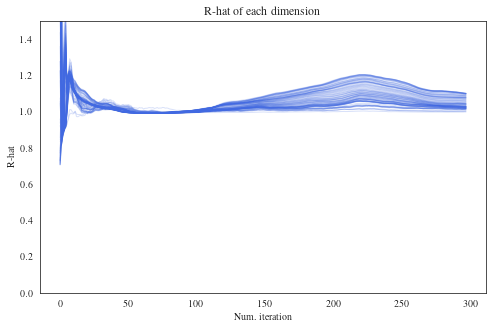

In [10]:
from numpyro.diagnostics import gelman_rubin


# Gelman-Rubin R_hat
r_hats = []

for i in range(2, theta_samples.shape[1]):
    r_hat_i = gelman_rubin(theta_samples[:, :i, :])
    r_hats.append(r_hat_i)

r_hats = np.array(r_hats)

print(r_hats.shape)

plt.plot(np.arange(len(r_hats)), r_hats, c='royalblue', alpha=0.2)
plt.xlabel('Num. iteration')
plt.ylabel('R-hat')
plt.ylim([0, 1.5])
plt.title('R-hat of each dimension')

### Compute Autocorrelation

In [11]:
from numpyro.diagnostics import autocorrelation


theta_sample = theta_samples[0]  # Pick one chain
print(theta_sample.shape)

# For all lags and all dimensions
autocorrs = autocorrelation(theta_sample[:, :])  # Size (T, D) = (120, 100)
autocorr_single = autocorrelation(theta_sample[0])

(300, 100)


#### Autocorrelation for all lags

Text(0, 0.5, 'Autocorrelation')

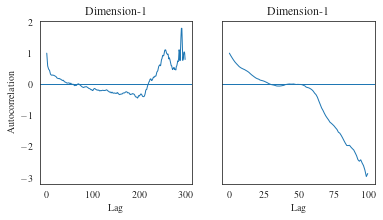

In [37]:
n_dim = 2
rand_idxs = np.random.randint(100, size=n_dim)  # 5 random dimensions

fig, axs = plt.subplots(1, n_dim, figsize=(6, 3), sharey=True)

axs[0].plot(np.arange(len(autocorrs)), autocorrs[:, 99])
axs[0].set_xlabel('Lag')
axs[0].set_title(f'Dimension-{0+1}')

axs[1].plot(np.arange(len(autocorr_single)), autocorr_single)
axs[1].set_xlabel('Lag')
axs[1].set_title(f'Dimension-{0+1}')

axs[0].axhline(y=0)
axs[1].axhline(y=0)

axs[0].set_ylabel('Autocorrelation')

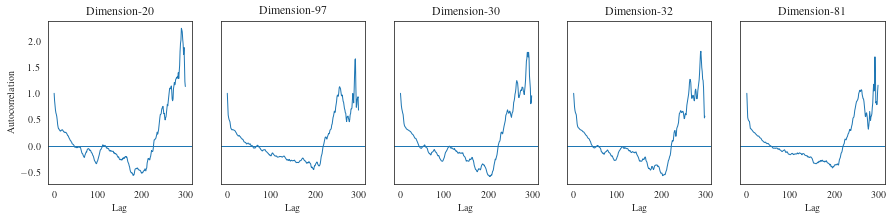

In [12]:
n_dim = 5
rand_idxs = np.random.randint(100, size=n_dim)  # 5 random dimensions

fig, axs = plt.subplots(1, n_dim, figsize=(15, 3), sharey=True)
for i in range(n_dim):
    axs[i].plot(np.arange(len(autocorrs)), autocorrs[:, rand_idxs[i]])
    axs[i].set_xlabel('Lag')
    axs[i].set_title(f'Dimension-{rand_idxs[i]+1}')

    axs[i].axhline(y=0)
    
    if i == 0:
        axs[i].set_ylabel('Autocorrelation')

#### Autocorrelation for a particular $k$

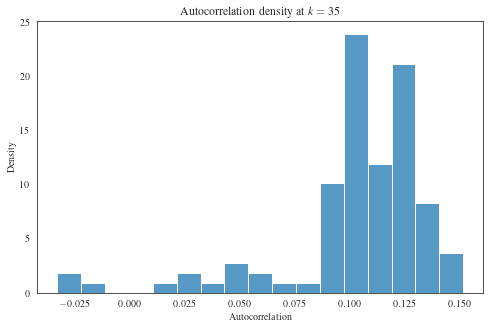

In [13]:
k = 35

sns.histplot(autocorrs[k, :], stat='density');
plt.xlabel('Autocorrelation');
plt.title(f'Autocorrelation density at $k={k}$');